In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras 
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model


modelPath = '/home/wz/HD1/wz/face/classification/inception_resnet_v2/inception_resnet_v2_check/checkpoint-27e-val_acc_0.685083.hdf5'
dataPath = '/home/wz/HD1/wz/face/新6类疾病patch1230/新6类疾病patch1230/val/'
rocSavePath ='/home/wz/HD1/wz/face/ROC'
rocTitle = 'Inception_resnet_v2'
batchSize = 32

classList = ['basal cell carcinoma', 
'lupus erythematosus',
'rosacea', 
'seborrheic keratosis', 
'solar keratosis',
'squamous carcinoma']

/home/wz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
valDataGen = ImageDataGenerator(rotation_range=0,
                              width_shift_range=0,
                              height_shift_range=0,
                              horizontal_flip=False,
                              vertical_flip=False,
                              fill_mode='nearest',
                              data_format='channels_last')

valGenerator = valDataGen.flow_from_directory(dataPath,
                                      target_size=(300,300), 
                                       color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=batchSize, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix=None,
                            save_format='jpeg',
                            follow_links=False)

Found 362 images belonging to 6 classes.


In [3]:
labelList = []
resultList = []

with tf.device('/gpu:0'):
    model = load_model(modelPath)
    
    for batch in range(len(valGenerator)):
        x, y = next(valGenerator)
        result = model.predict_on_batch(x)
        resultList.extend(list(result))
        labelList.extend(list(y))
    #result = model.evaluate_generator(valGenerator , steps=valNumber/batchSize, max_queue_size=64, workers=1, use_multiprocessing=False, verbose=1)
    #result = model.predict_generator(valGenerator, steps=valNumber/batchSize, max_queue_size=64, workers=1, use_multiprocessing=False, verbose=1)

In [4]:
classDict = valGenerator.class_indices
labelList = [list(i) for i in labelList]
labelList = [i.index(max(i)) for i in labelList ]
classDict2 = dict(zip(classDict.values(),classDict.keys()))

In [11]:
import re
import numpy as np  
import matplotlib.pyplot as plt    
from sklearn.metrics import roc_curve, auc  ###计算roc和auc  


# LABELS为数字化标签与文字标签对应的dict，key为数字
# y_pred_scores为模型输出,np.array类型，如64个样本，6类，则其 shape应为(64,6)，每个元素都是概率值
# y_true为标签列表
LABELS = classDict2
y_score = np.array(resultList)
y_true = labelList

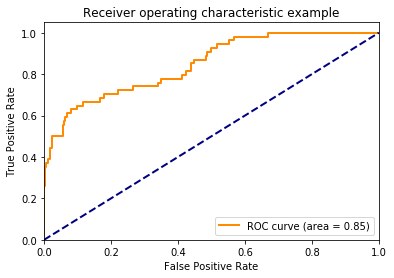

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# 将标签转为one-hot形式
# label_binarize函数API为：
# label_binarize([1, 6], classes=[1, 2, 4, 6])
# 输出：array([[1, 0, 0, 0],[0, 0, 0, 1]])

# classes为数字化标签
classes = list(LABELS.keys())
y = label_binarize(y_true, classes=classes)
n_classes = y.shape[1]




# 对每一类计算roc画出roc曲线
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算micro-average ROC曲线和其ROC面积(AUC)
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# 选取其中一类画出
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

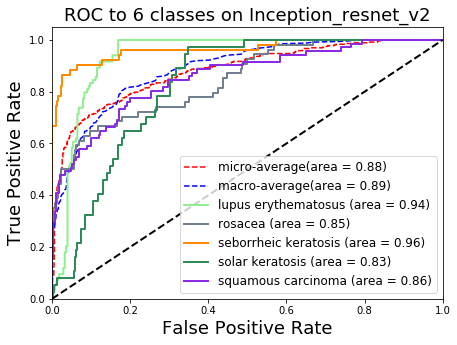

In [13]:
# 计算macro-average ROC曲线和其ROC面积(AUC)

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(1,n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes-1

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 画出micro曲线和macro曲线
plt.figure(figsize=(7,5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average(area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='red', linestyle='--')

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average(area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='blue', linestyle='--')

# 每条曲线的颜色选取，在给出的颜色中循环
colors = cycle(['lightgreen','slategray','darkorange','seagreen','blueviolet','red','gold','dodgerblue','blue'])
#colors = cycle(['red','blue'])
#colors = cycle(['blue','red'])

# 画出每一类的ROC曲线
for i, color in zip(range(1,n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(LABELS[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)

plt.title('ROC to {0} classes on {1}'.format(n_classes,rocTitle),fontsize=18)
plt.legend(loc="lower right",fontsize=12)
plt.savefig(os.path.join(rocSavePath,'{0}-roc.jpg'.format(rocTitle)), dpi=300)
plt.show()